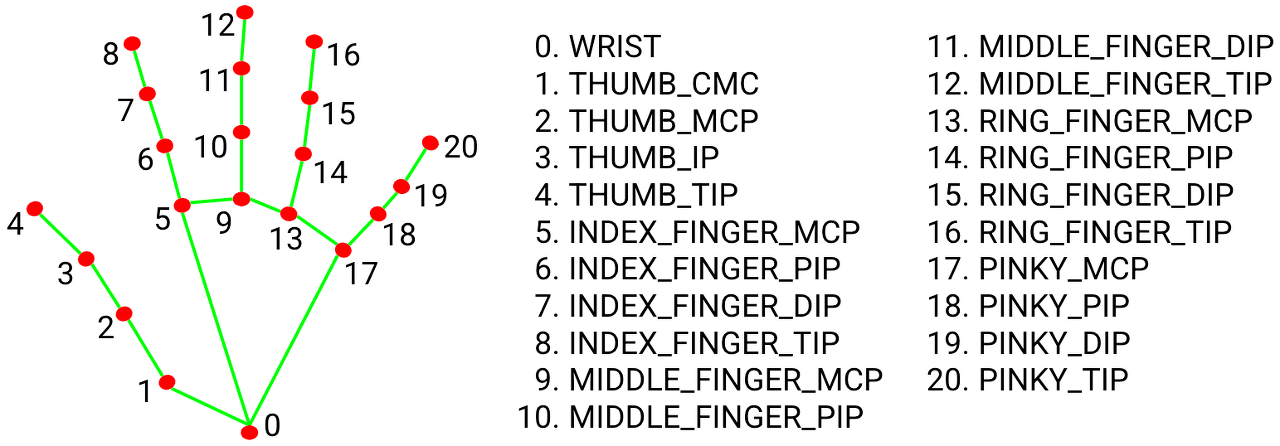

In [1]:
import cv2
import mediapipe as mp
import copy
import csv
import numpy as np
import itertools
import tensorflow as tf

from keypoint_classifier import KeyPointClassifier

In [27]:
!pip install --upgrade tensorflow==2.7.0


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
print(tf.__version__)

2.7.0


In [2]:
mp_hand = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

In [3]:
hand = mp_hand.Hands(max_num_hands=2, static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
keypoint_classifier = KeyPointClassifier()
with open('model/keypoint_classifier/keypoint_classifier_label.csv',
              encoding='utf-8-sig') as f:
        keypoint_classifier_labels = csv.reader(f)
        keypoint_classifier_labels = [
            row[0] for row in keypoint_classifier_labels
        ]

In [4]:
def select_mode(key, mode):
    number = -1
    if 48 <= key <= 57:  # 0 ~ 9
        number = key - 48
    if key == 110:  # n
        mode = 0
    if key == 107:  # k
        mode = 1
    if key == 104:  # h
        mode = 2
    return number, mode

In [5]:
def calc_landmark_list(image_width, image_height, landmarks):

    landmark_point = []

    # キーポイント
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

In [6]:
def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # 相対座標に変換
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            # 0 wrist 값 기준으로 상대거리 계산
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # 1次元リストに変換
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # 正規化 정규화
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list


In [7]:
csv_path = 'keypoint_common.csv'
with open(csv_path, 'a', newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["count", "label", "wrist_x", "wrist_y", 'thumb_cmc_x', "thumb_cmc_y", "thumb_mcp_x", "thumb_mcp_y", "thumb_ip_x", "thumb_ip_y", "thumb_tip_x", "thumb_tip_y", "index_finger_mcp_x", "index_finger_mcp_y", "index_finger_pip_x", "index_finger_pip_y", "index_finger_dip_x", "index_finger_dip_y", "index_finger_tip_x", "index_finger_tip_y", "middle_finger_mcp_x", "middle_finger_mcp_y", "middle_finger_pip_x", "middle_finger_pip_y", "middle_finger_dip_x", "middle_finger_dip_y", "middle_finger_tip_x", "middle_finger_tip_y", "ring_finger_mcp_x", "ring_finger_mcp_y", "ring_finger_pip_x", "ring_finger_pip_y", "ring_finger_dip_x", "ring_finger_dip_y", "ring_finger_tip_x", "ring_finger_tip_y", "pinky_mcp_x", "pinky_mcp_y", "pinky_pip_x", "pinky_pip_y", "pinky_dip_x", "pinky_dip_y", "pinky_tip_x", "pinky_tip_y"])

In [8]:
def logging_csv(number, mode, landmark_list, count):
    if mode == 0:
        pass
    if mode == 1 and number==1:
        # csv_path = 'model/keypoint_classifier/keypoint.csv'
        label = -1
        with open(csv_path, 'a', newline="") as f:
            writer = csv.writer(f)
            writer.writerow([count, label, *landmark_list])
    
    # if mode == 2 and (0 <= number <= 9):
    #     csv_path = 'model/point_history_classifier/point_history.csv'
    #     with open(csv_path, 'a', newline="") as f:
    #         writer = csv.writer(f)
    #         writer.writerow([number, *point_history_list])
    return

In [9]:
mode = 0
label = 0
count = 1
frame_cnt = 0
import matplotlib.pyplot as plt
while True:
    ret, frame = cap.read()
    if not ret:
        print("fail")
        break
    res = hand.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    key = cv2.waitKey(10)
    number, mode = select_mode(key, mode)
    if number == 2:
        count +=1
    image_width, image_height = frame.shape[1], frame.shape[0]
    # image = copy.deepcopy(frame)
    # image = cv2.flip(image, 1)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if res.multi_hand_landmarks:
        for landmarks in res.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, landmarks, mp_hand.HAND_CONNECTIONS, mp_styles.get_default_hand_landmarks_style(), mp_styles.get_default_hand_connections_style())

            
            landmark_list = calc_landmark_list(image_width, image_height, landmarks)
            pre_processed_landmark_list = pre_process_landmark(landmark_list)
            logging_csv(number, mode, pre_processed_landmark_list, count)
            if number == 1:
                frame_cnt+=1
                print("frame_count", frame_cnt, "\tgesture_count", count)
            hand_sign_id = keypoint_classifier(pre_processed_landmark_list, label)
            if hand_sign_id != None and hand_sign_id != 0:
                print(hand_sign_id)
            # plt.plot(hand_sign_id)
            # plt.show()
            

    cv2.imshow("MediaPipe Hands", cv2.flip(frame, 1))
    if cv2.waitKey(5)==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
